![Lego](https://www.lego.com/cdn/cs/set/assets/blt43d71bdb7a2ee793/pick-a-brick-banner-background-large.jpg?width=1320&height=200&dpr=1)

# Lego - Linear Regression

<b>Hypothesis: Can we predict the price of a lego set ?</b>

### Steps for Linear Regression
1. Data collection
2. Data cleaning
3. Linear regression
4. Checking assumptions
5. Results: final linear regression and assumptions

## Importing Librairies

In [98]:
import pandas as pd
from  datetime import datetime
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from scipy.stats import boxcox

# Checking assumptions
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.stattools import durbin_watson
import numpy as np
from scipy.special import boxcox, inv_boxcox
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import kstest
from scipy.stats import probplot
import pylab

## 1. Data collection

In [99]:
path_data = r"C:/Users/Camille/Documents/Ecole/Ironhack/Week 6/Group_project/lego/data-tidy"

lego2 = pd.read_csv(path_data+"/legosets.csv")

In [100]:
lego2.Item_Number.nunique()

5854

In [101]:
lego2.shape

(6172, 14)

In [102]:
lego2.head()

,Item_Number,Name,Year,Theme,Subtheme,Pieces,Minifigures,Image_URL,GBP_MSRP,USD_MSRP,CAD_MSRP,EUR_MSRP,Packaging,Availability
0,10246,Detective's Office,2015,Advanced Models,Modular Buildings,2262.0,6.0,http://images.brickset.com/sets/images/10246-1...,132.99,159.99,199.99,149.99,Box,Retail - limited
1,10247,Ferris Wheel,2015,Advanced Models,Fairground,2464.0,10.0,http://images.brickset.com/sets/images/10247-1...,149.99,199.99,229.99,179.99,Box,Retail - limited
2,10248,Ferrari F40,2015,Advanced Models,Vehicles,1158.0,NaN,http://images.brickset.com/sets/images/10248-1...,69.99,99.99,119.99,89.99,Box,LEGO exclusive
3,10249,Toy Shop,2015,Advanced Models,Winter Village,898.0,NaN,http://images.brickset.com/sets/images/10249-1...,59.99,79.99,NaN,69.99,Box,LEGO exclusive
4,10581,Ducks,2015,Duplo,Forest Animals,13.0,1.0,http://images.brickset.com/sets/images/10581-1...,9.99,9.99,12.99,9.99,Box,Retail


## 2. Data cleaning
* Checking missing values 
* Checking whether there are duplicates
* Cleaning column per column
* Creating dummies for non-numerical columns
* Transforming numerical columns to be normally distributed
* Identifying outliers

### 2.1. Checking missing values

In [103]:
missing = lego2.isna().sum()

In [104]:
missing[missing > 0]

Subtheme       2206
Pieces          112
Minifigures    2672
GBP_MSRP       1980
USD_MSRP        355
CAD_MSRP       4190
EUR_MSRP       4399
dtype: int64

7 columns have missing rows

### 2.2. Checking duplicate rows

In [105]:
duplicates=lego2.loc[lego2.Item_Number.duplicated()==True]
duplicates.head()

,Item_Number,Name,Year,Theme,Subtheme,Pieces,Minifigures,Image_URL,GBP_MSRP,USD_MSRP,CAD_MSRP,EUR_MSRP,Packaging,Availability
296,71008,Classic King,2015,Collectable Minifigures,Series 13,9.0,1.0,http://images.brickset.com/sets/images/71008-1...,2.49,3.99,NaN,NaN,Foil pack,Retail
297,71008,Sheriff,2015,Collectable Minifigures,Series 13,8.0,1.0,http://images.brickset.com/sets/images/71008-2...,2.49,3.99,NaN,NaN,Foil pack,Retail
298,71008,Unicorn Girl,2015,Collectable Minifigures,Series 13,6.0,1.0,http://images.brickset.com/sets/images/71008-3...,2.49,3.99,NaN,NaN,Foil pack,Retail
299,71008,Snake Charmer,2015,Collectable Minifigures,Series 13,7.0,1.0,http://images.brickset.com/sets/images/71008-4...,2.49,3.99,NaN,NaN,Foil pack,Retail
300,71008,Goblin,2015,Collectable Minifigures,Series 13,7.0,1.0,http://images.brickset.com/sets/images/71008-5...,2.49,3.99,NaN,NaN,Foil pack,Retail


In [106]:
duplicates.loc[duplicates.Name.duplicated()==True]

,Item_Number,Name,Year,Theme,Subtheme,Pieces,Minifigures,Image_URL,GBP_MSRP,USD_MSRP,CAD_MSRP,EUR_MSRP,Packaging,Availability
3278,4105,50th Anniversary Bucket,2005,Make and Create,NaN,500.0,NaN,http://images.brickset.com/sets/images/4105-2.jpg,9.99,10.0,NaN,NaN,Not specified,Not specified
4121,4105,Creator Bucket,2002,Creator,NaN,500.0,NaN,http://images.brickset.com/sets/images/4105-1.jpg,9.99,10.0,NaN,NaN,Bucket,Retail


Conclusion: There are no real duplicates as all duplicates in Item_number actually have different names. No actions are taken on this

### 2.3. Cleaning column per column

#### a. Cleaning currency columns 

In [107]:
# drop price columns
lego2.drop("GBP_MSRP", axis=1, inplace=True)
lego2.drop("CAD_MSRP", axis=1, inplace=True)
lego2.drop("EUR_MSRP", axis=1, inplace=True)

In [108]:
# drop nan rows in USD
lego2 = lego2[lego2.USD_MSRP.notna()]

In [109]:
# drop 0 rows in USD
lego2 = lego2[lego2.USD_MSRP > 0]

In [110]:
# renaming the column USD 
lego2.rename(columns = {"USD_MSRP":"Price_USD"}, inplace=True)

#### b. Cleaning number of pieces

In [111]:
# drop 0 rows in pieces
lego2 = lego2[lego2.Pieces > 0]

In [112]:
lego2.isna().sum()

Item_Number        0
Name               0
Year               0
Theme              0
Subtheme        1998
Pieces             0
Minifigures     2255
Image_URL          0
Price_USD          0
Packaging          0
Availability       0
dtype: int64

In [113]:
# drop nan rows in piece
lego2 = lego2[lego2.Pieces.notna()]

In [114]:
lego2.isna().sum()

Item_Number        0
Name               0
Year               0
Theme              0
Subtheme        1998
Pieces             0
Minifigures     2255
Image_URL          0
Price_USD          0
Packaging          0
Availability       0
dtype: int64

#### c. Cleaning Minifigures

In [115]:
# drop nan for minifigures rows
lego2 = lego2[lego2.Minifigures.notna()]

In [116]:
lego2.isna().sum()

Item_Number       0
Name              0
Year              0
Theme             0
Subtheme        991
Pieces            0
Minifigures       0
Image_URL         0
Price_USD         0
Packaging         0
Availability      0
dtype: int64

#### d. Dropping columns

In [117]:
# drop itemnumber, name 
lego2.drop("Subtheme", axis=1, inplace=True)
lego2.drop("Image_URL", axis=1, inplace=True)
lego2.drop("Item_Number", axis=1, inplace=True)
lego2.drop("Name", axis=1, inplace=True)

#### e. Cleaning age

In [118]:
# create age column
lego2["age"] = datetime.now().year-lego2.Year

In [119]:
# drop year column
lego2.drop("Year", axis=1, inplace=True)

#### f. Cleaning Themes

In [120]:
# regroup Themes
lst_theme = list(lego2.Theme.value_counts().head(10).index)
lst_theme

['Duplo',
 'Star Wars',
 'Town',
 'City',
 'Collectable Minifigures',
 'Castle',
 'Space',
 'Ninjago',
 'Friends',
 'Legends of Chima']

In [121]:
lego2.Theme = lego2.apply(lambda row : "Other" if row["Theme"] not in lst_theme else row["Theme"], axis=1)

In [122]:
lego2.Theme.value_counts()

Other                      1352
Duplo                       299
Star Wars                   290
Town                        283
City                        262
Collectable Minifigures     255
Castle                      173
Space                       153
Ninjago                     111
Friends                      87
Legends of Chima             81
Name: Theme, dtype: int64

### 2.4. Creating dummies

In [123]:
dummies_list = ["Theme","Availability","Packaging"]

In [124]:
# creating dummies for Theme, Availability, Packaging
lego3 = pd.get_dummies(data=lego2, columns=dummies_list, drop_first=True)

In [125]:
lego3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3346 entries, 0 to 6070
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Pieces                              3346 non-null   float64
 1   Minifigures                         3346 non-null   float64
 2   Price_USD                           3346 non-null   float64
 3   age                                 3346 non-null   int64  
 4   Theme_City                          3346 non-null   uint8  
 5   Theme_Collectable Minifigures       3346 non-null   uint8  
 6   Theme_Duplo                         3346 non-null   uint8  
 7   Theme_Friends                       3346 non-null   uint8  
 8   Theme_Legends of Chima              3346 non-null   uint8  
 9   Theme_Ninjago                       3346 non-null   uint8  
 10  Theme_Other                         3346 non-null   uint8  
 11  Theme_Space                         3346 no

### 2.5. Transforming Numeric data into Normal Distribution
* Looking at current numerical distribution
* Transforming them using the boxcox method
* Checking whether the transformed variables are normally distributed

#### a. Checking current distribution for numerical columns
* Number of pieces 
* Price
* Age 
* Number of Minifigures

Text(0.5, 1.0, 'Distribution of number of pieces')

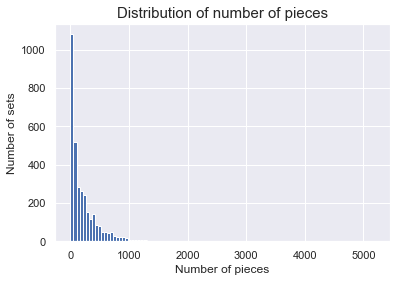

In [126]:
# Number of pieces
lego3.Pieces.hist(bins=100)
plt.ylabel("Number of sets")
plt.xlabel("Number of pieces")
plt.title("Distribution of number of pieces", fontsize=15)

Text(0.5, 1.0, 'Distribution of prices')

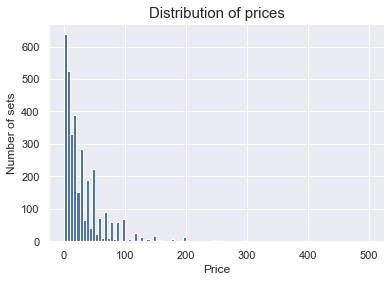

In [127]:
#Prices
lego3.Price_USD.hist(bins=100)
plt.ylabel("Number of sets")
plt.xlabel("Price")
plt.title("Distribution of prices", fontsize=15)

Text(0.5, 1.0, 'Distribution of ages')

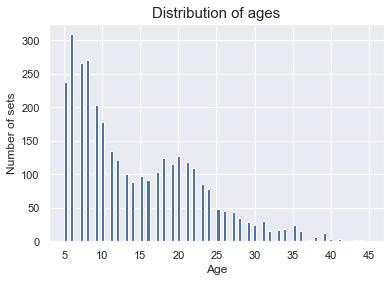

In [128]:
# Age
lego3.age.hist(bins=100)
plt.ylabel("Number of sets")
plt.xlabel("Age")
plt.title("Distribution of ages", fontsize=15)

Text(0.5, 1.0, 'Distribution of number of minifigures')

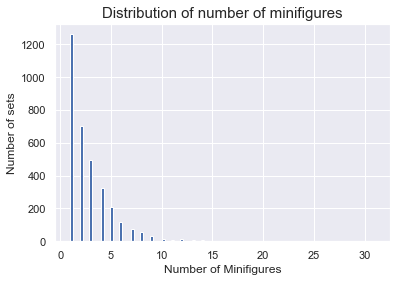

In [129]:
#Minifigures
lego3.Minifigures.hist(bins=100)
plt.ylabel("Number of sets")
plt.xlabel("Number of Minifigures")
plt.title("Distribution of number of minifigures", fontsize=15)

None of them are normally distributed

#### b. Transforming them to be normally distributed

In [130]:
# transform numeric columns to normal distribution
lego3["Pieces2"] = boxcox(lego3.Pieces, 0)
lego3["Price_USD2"] = boxcox(lego3.Price_USD, 0)
lego3["age2"] = boxcox(lego3.age, 0)
lego3["Minifigures2"] = boxcox(lego3.Minifigures, 0)

#### c. Checking the new distribution

Text(0.5, 1.0, 'Distribution of number of pieces - transformed')

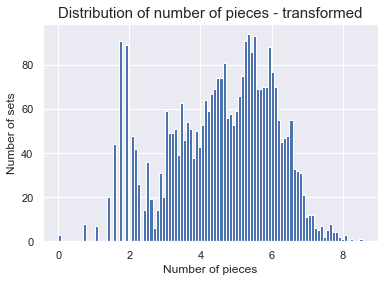

In [131]:
# Number of pieces
lego3.Pieces2.hist(bins=100)
plt.ylabel("Number of sets")
plt.xlabel("Number of pieces")
plt.title("Distribution of number of pieces - transformed", fontsize=15)

Text(0.5, 1.0, 'Distribution of prices - transformed')

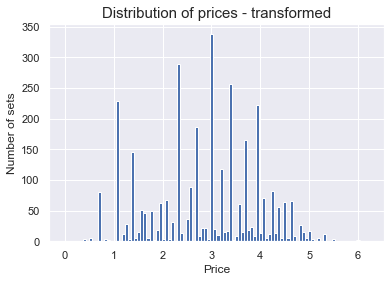

In [132]:
lego3.Price_USD2.hist(bins=100)
plt.ylabel("Number of sets")
plt.xlabel("Price")
plt.title("Distribution of prices - transformed", fontsize=15)

Text(0.5, 1.0, 'Distribution of ages')

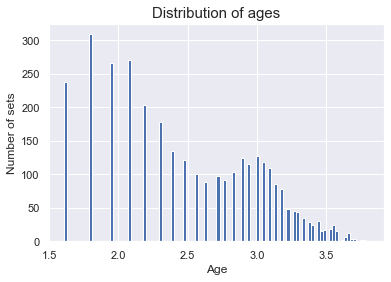

In [133]:
# Ages
lego3.age2.hist(bins=100)
plt.ylabel("Number of sets")
plt.xlabel("Age")
plt.title("Distribution of ages", fontsize=15)

Text(0.5, 1.0, 'Distribution of Minifigures')

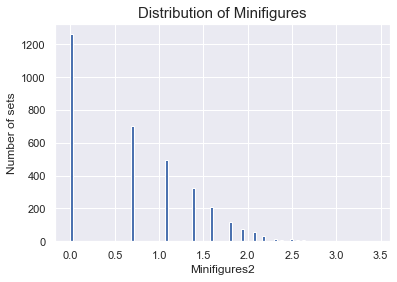

In [135]:
# Minifigures
lego3.Minifigures2.hist(bins=100)
plt.ylabel("Number of sets")
plt.xlabel("Minifigures2")
plt.title("Distribution of Minifigures", fontsize=15)

In [134]:
lego4 = lego3.drop(["Pieces","Price_USD","age","Minifigures"], axis=1)

### 2.6. Identifying outliers

#### a. Prices outliers

In [136]:
Q1_Price= lego4.Price_USD2.quantile(0.25)
Q3_Price = lego4.Price_USD2.quantile(0.75)
IQR_Price = Q3_Price - Q1_Price
IQR_Price

1.609187881178891

In [137]:
Outlierbottom_Price=Q1_Price-IQR_Price*1.5

In [138]:
Outliertop_Price=Q3_Price+IQR_Price*1.5

Text(0.5, 1.0, 'Price outliers')

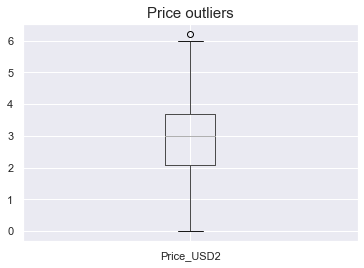

In [139]:
lego4.boxplot(column=['Price_USD2'])
plt.title("Price outliers", fontsize=15)

#### b. Number of pieces outliers

In [140]:
#Identifying outliers for Pieces
Q1_Piece = lego4.Pieces2.quantile(0.25)
Q3_Piece = lego4.Pieces2.quantile(0.75)
IQR_Piece = Q3_Piece - Q1_Piece
IQR_Piece

2.1832373046022093

In [141]:
Outlierbottom_Piece=Q1_Piece-IQR_Piece*1.5

In [142]:
Outliertop_Piece=Q3_Piece+IQR_Piece*1.5

Text(0.5, 1.0, 'Number of pieces outliers')

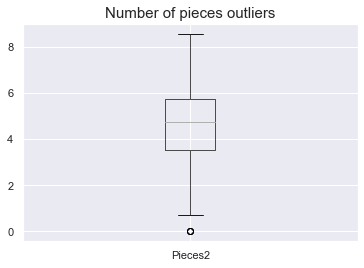

In [143]:
lego4.boxplot(column=['Pieces2'])
plt.title("Number of pieces outliers", fontsize=15)

#### c. Minifigures outliers

In [144]:
#Identifying outliers for Pieces
Q1_Mini = lego4.Minifigures2.quantile(0.25)
Q3_Mini = lego4.Minifigures2.quantile(0.75)
IQR_Mini = Q3_Mini - Q1_Mini
IQR_Mini

1.3862943611198906

In [145]:
Outlierbottom_Mini=Q1_Mini-IQR_Mini*1.5
Outlierbottom_Mini

-2.0794415416798357

In [146]:
Outliertop_Mini=Q3_Mini+IQR_Mini*1.5
Outliertop_Mini

3.465735902799726

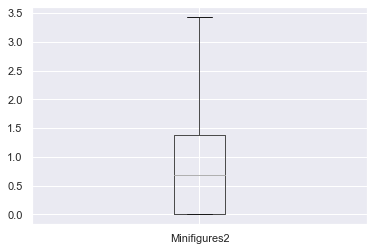

In [147]:
lego4.boxplot(column=['Minifigures2'])

#### d. Creating booleans columns for outliers

In [148]:
lego4["Outliers_Price"]=lego4.apply(lambda row : 0 if Outlierbottom_Price<row.Price_USD2<Outliertop_Price  else 1, axis=1)
lego4["Outliers_Piece"]=lego4.apply(lambda row : 0 if Outlierbottom_Piece<row.Pieces2<Outliertop_Piece  else 1, axis=1)
lego4["Outliers_Minifigures"]=lego4.apply(lambda row : 0 if Outlierbottom_Mini<row.Minifigures2<Outliertop_Mini  else 1, axis=1)

In [149]:
lego4.head()

,Theme_City,Theme_Collectable Minifigures,Theme_Duplo,Theme_Friends,Theme_Legends of Chima,Theme_Ninjago,Theme_Other,Theme_Space,Theme_Star Wars,Theme_Town,...,Packaging_Plastic box,Packaging_Polybag,Packaging_Tub,Pieces2,Price_USD2,age2,Minifigures2,Outliers_Price,Outliers_Piece,Outliers_Minifigures
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,7.724005,5.075111,1.609438,1.791759,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,7.809541,5.298267,1.609438,2.302585,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,2.564949,2.301585,1.609438,0.000000,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,3.663562,2.995232,1.609438,0.693147,0,0,0
6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,3.465736,3.218476,1.609438,0.693147,0,0,0


### 2.7. Drop minifigures

In [150]:
lego5 = lego4.drop(["Minifigures2"], axis=1)

In [151]:
lego5.loc[(lego5.Pieces2.duplicated()==True)&(lego5.Price_USD2.duplicated()==True)]

,Theme_City,Theme_Collectable Minifigures,Theme_Duplo,Theme_Friends,Theme_Legends of Chima,Theme_Ninjago,Theme_Other,Theme_Space,Theme_Star Wars,Theme_Town,...,Packaging_Other,Packaging_Plastic box,Packaging_Polybag,Packaging_Tub,Pieces2,Price_USD2,age2,Outliers_Price,Outliers_Piece,Outliers_Minifigures
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,2.564949,2.301585,1.609438,0,0,0
11,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,2.564949,2.707383,1.609438,0,0,0
65,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,3.663562,1.383791,1.609438,0,0,0
119,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,4.465908,2.301585,1.609438,0,0,0
124,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,4.584967,2.301585,1.609438,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6030,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1.098612,4.317488,3.713572,0,0,0
6033,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,4.812184,1.098612,3.713572,0,0,0
6038,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,5.135798,2.302585,3.737670,0,0,0
6050,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,5.308268,2.708050,3.784190,0,0,0


### Final cleaned dataset:

In [152]:
lego5.describe()

,Theme_City,Theme_Collectable Minifigures,Theme_Duplo,Theme_Friends,Theme_Legends of Chima,Theme_Ninjago,Theme_Other,Theme_Space,Theme_Star Wars,Theme_Town,...,Packaging_Other,Packaging_Plastic box,Packaging_Polybag,Packaging_Tub,Pieces2,Price_USD2,age2,Outliers_Price,Outliers_Piece,Outliers_Minifigures
count,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,...,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.0
mean,0.078302,0.076210,0.089360,0.026001,0.024208,0.033174,0.404065,0.045726,0.086671,0.084579,...,0.004782,0.002092,0.031381,0.004184,4.578073,2.870964,2.511196,0.000299,0.000897,0.0
std,0.268687,0.265374,0.285306,0.159163,0.153717,0.179117,0.490783,0.208922,0.281394,0.278295,...,0.068996,0.045698,0.174371,0.064559,1.483384,1.098402,0.561896,0.017288,0.029934,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010050,1.609438,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.526361,2.079442,2.079442,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.736198,2.995232,2.484907,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.709598,3.688629,2.995732,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,8.555452,6.214588,3.806662,1.000000,1.000000,0.0


In [153]:
lego5.head()

,Theme_City,Theme_Collectable Minifigures,Theme_Duplo,Theme_Friends,Theme_Legends of Chima,Theme_Ninjago,Theme_Other,Theme_Space,Theme_Star Wars,Theme_Town,...,Packaging_Other,Packaging_Plastic box,Packaging_Polybag,Packaging_Tub,Pieces2,Price_USD2,age2,Outliers_Price,Outliers_Piece,Outliers_Minifigures
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,7.724005,5.075111,1.609438,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,7.809541,5.298267,1.609438,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,2.564949,2.301585,1.609438,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,3.663562,2.995232,1.609438,0,0,0
6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,3.465736,3.218476,1.609438,0,0,0


## 3. Linear regression model

In [154]:
def func(column,X):
    #drop the column
    if column:
        X=X.drop(column, axis=1)
    # build the model
    model=sm.OLS(y,add_constant(X))
    #fit it
    model_fit=model.fit()
    #display the model
    display(model_fit.summary())
    #return X without the column
    return X

In [155]:
# Running the model for the first time
y=lego5.Price_USD2
X=lego5.drop('Price_USD2',axis=1)

model=sm.OLS(y,add_constant(X))
model_fit=model.fit()
model_fit.summary()

C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Price_USD2   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     566.0
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        14:47:17   Log-Likelihood:                -2077.8
No. Observations:                3346   AIC:                             4216.
Df Residuals:                    3316   BIC:                             4399.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.1246      0.105     -1.191      0.234      -0.330       0.080
Theme_City                             0.2316      0.047      4.957      0.000       0.140       0.323
Theme_Collectable Minifigures          0.0919      0.066      1.400      0.162      -0.037       0.221
Theme_Duplo                            1.2717      0.048     26.536      0.000       1.178       1.366
Theme_Friends                          0.1415      0.063      2.253      0.024       0.018       0.265
Theme_Legends of Chima                 0.0194      0.068      0.285      0.775      -0.114       0.153
Theme_Ninjago                          0.1600      0.060      2.654      0.008       0.042       0.278
Theme_Other                            0.2627      0.037      7.046      0.000       0.190       0.336
Theme_Space                           -0.0054      0.050     -0.108      0.914      -0.104       0.093
Theme_Star Wars                        0.1585      0.045      3.488      0.000       0.069       0.248
Theme_Town                            -0.0023      0.045     -0.052      0.958      -0.090       0.085
Availability_Not specified             0.0479      0.167      0.287      0.774      -0.279       0.375
Availability_Promotional              -0.3620      0.072     -4.995      0.000      -0.504      -0.220
Availability_Promotional (Airline)    -0.2451      0.151     -1.622      0.105      -0.541       0.051
Availability_Retail                   -0.2160      0.044     -4.876      0.000      -0.303      -0.129
Availability_Retail - limited         -0.2246      0.051     -4.375      0.000      -0.325      -0.124
Availability_Unknown                  -1.4700      0.455     -3.233      0.001      -2.362      -0.578
Packaging_Box                         -0.5905      0.070     -8.393      0.000      -0.728      -0.453
Packaging_Box with backing card       -0.3481      0.134     -2.602      0.009      -0.610      -0.086
Packaging_Bucket                      -1.2334      0.149     -8.268      0.000      -1.526      -0.941
Packaging_Foil pack                   -0.0326      0.088     -0.371      0.711      -0.205       0.140
Packaging_Not specified               -0.4773      0.177     -2.690      0.007      -0.825      -0.129
Packaging_Other                       -0.4446      0.134     -3.318      0.001      -0.707      -0.182
Packaging_Plastic box                  2.2215      0.232      9.556      0.000       1.766       2.677
Packaging_Polybag                     -0.9382      0.084    -11.112      0.000      -1.104      -0.773
Packaging_Tub                         -0.9389      0.141     -6.653      0.000      -1.216      -0.662
Pieces2                                0.7360      0.008     93.909      0.000       0.721      

### Cleaning pvalues

In [249]:
["Theme_Town","Theme_Space","Availability_Not specified","Theme_Legends of Chima","Packaging_Foil pack","age2","Outliers_Price","Theme_Collectable Minifigures","Availability_Promotional (Airline)"]

['Theme_Town',
 'Theme_Space',
 'Availability_Not specified',
 'Theme_Legends of Chima',
 'Packaging_Foil pack',
 'age2',
 'Outliers_Price',
 'Theme_Collectable Minifigures',
 'Availability_Promotional (Airline)']

In [164]:
X=func("Availability_Promotional (Airline)",X)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Price_USD2   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     821.1
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        14:48:54   Log-Likelihood:                -2080.8
No. Observations:                3346   AIC:                             4204.
Df Residuals:                    3325   BIC:                             4332.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0549      0.052     -1.057      0.290      -0.157       0.047
Theme_City                          0.2164      0.033      6.584      0.000       0.152       0.281
Theme_Duplo                         1.2444      0.033     37.149      0.000       1.179       1.310
Theme_Friends                       0.1227      0.052      2.381      0.017       0.022       0.224
Theme_Ninjago                       0.1325      0.046      2.872      0.004       0.042       0.223
Theme_Other                         0.2508      0.021     12.002      0.000       0.210       0.292
Theme_Star Wars                     0.1470      0.032      4.531      0.000       0.083       0.211
Availability_Promotional           -0.3523      0.070     -5.001      0.000      -0.490      -0.214
Availability_Retail                -0.1994      0.041     -4.874      0.000      -0.280      -0.119
Availability_Retail - limited      -0.2087      0.049     -4.284      0.000      -0.304      -0.113
Availability_Unknown               -1.4513      0.454     -3.196      0.001      -2.342      -0.561
Packaging_Box                      -0.6102      0.038    -16.083      0.000      -0.685      -0.536
Packaging_Box with backing card    -0.3705      0.121     -3.051      0.002      -0.609      -0.132
Packaging_Bucket                   -1.2445      0.136     -9.122      0.000      -1.512      -0.977
Packaging_Not specified            -0.4219      0.053     -7.977      0.000      -0.526      -0.318
Packaging_Other                    -0.4740      0.119     -3.980      0.000      -0.707      -0.240
Packaging_Plastic box               2.2445      0.180     12.478      0.000       1.892       2.597
Packaging_Polybag                  -0.9616      0.062    -15.562      0.000      -1.083      -0.840
Packaging_Tub                      -0.9542      0.128     -7.462      0.000      -1.205      -0.704
Pieces2                             0.7318      0.007    102.953      0.000       0.718       0.746
Outliers_Piece                      1.9922      0.263      7.561      0.000       1.476       2.509
Outliers_Minifigures                     0          0        nan        nan           0           0
==============================================================================
Omnibus:                      575.167   Durbin-Watson:                   1.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3719.443
Skew:                           0.654   Prob(JB):                         0.00
Kurtosis:                       7.997   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] Th

## 4. Checking assumptions
The Assumption function is defined in another python file

Fitting linear regression

R^2: 0.8316186581894514 

Coefficients
-------------------------------------
Intercept: -0.054935920340766664
Theme_City: 0.22
Theme_Duplo: 1.24
Theme_Friends: 0.12
Theme_Ninjago: 0.13
Theme_Other: 0.25
Theme_Star Wars: 0.15
Availability_Promotional: -0.35
Availability_Retail: -0.2
Availability_Retail - limited: -0.21
Availability_Unknown: -1.45
Packaging_Box: -0.61
Packaging_Box with backing card: -0.37
Packaging_Bucket: -1.24
Packaging_Not specified: -0.42
Packaging_Other: -0.47
Packaging_Plastic box: 2.24
Packaging_Polybag: -0.96
Packaging_Tub: -0.95
Pieces2: 0.73
Outliers_Piece: 1.99
Outliers_Minifigures: 0.0

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


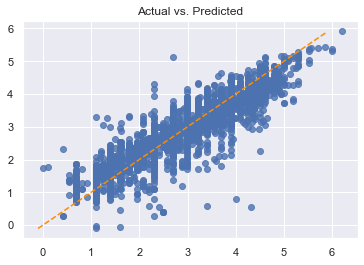

If non-linearity is apparent, consider adding a polynomial term 
		or using box-cox transformation to make X or y follow normal distribution



Building a correlation table


Parameters that are most likely VIOLATE linearity assumption and their correlation with Price_USD2


Series([], Name: Price_USD2, dtype: float64)


Parameters that are most likely FOLLOW linearity assumption and their correlation with Price_USD2


Pieces2    0.827721
Name: Price_USD2, dtype: float64


Assumption 2: Little to no multicollinearity among predictors


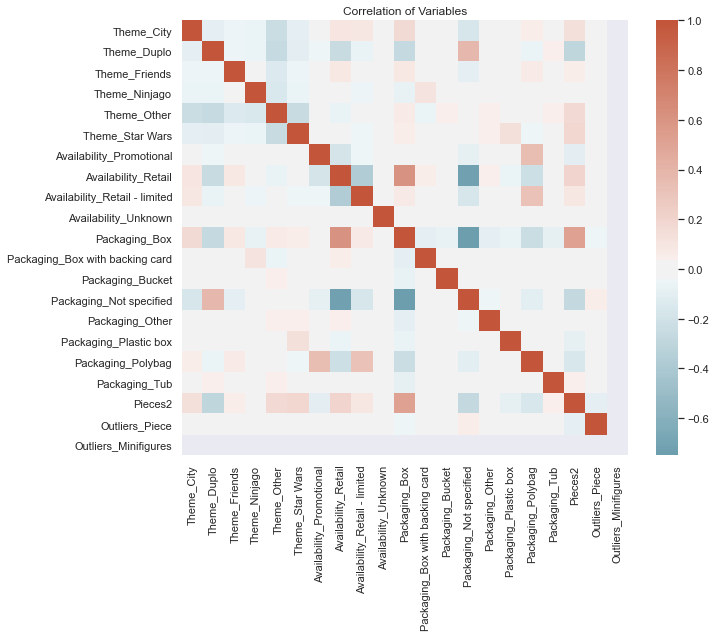

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------


C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Pieces2: 16.548876730386088
Packaging_Box: 14.093998827584944
Availability_Retail: 7.308210723060135
Packaging_Not specified: 4.465775423542481
Theme_Other: 2.887153340393272
Availability_Retail - limited: 2.0671999873460187
Packaging_Polybag: 1.7636925224790965
Theme_Duplo: 1.6288663998811874
Theme_Star Wars: 1.4913333680451417
Theme_City: 1.3828690403049484
Availability_Promotional: 1.3790303519863751
Theme_Ninjago: 1.1535280316267835
Theme_Friends: 1.1294512981098475
Packaging_Tub: 1.1175522806745666
Packaging_Other: 1.1030462771540241
Packaging_Bucket: 1.0894832889344472
Packaging_Box with backing card: 1.0761415197842543
Packaging_Plastic box: 1.0283992257956338
Outliers_Piece: 1.0172547799966072
Availability_Unknown: 1.0037359377704531
Outliers_Minifigures: nan

2 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor

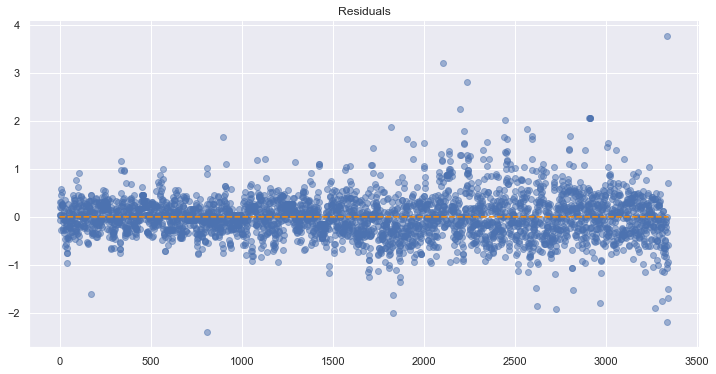

If heteroskedasticity is apparent, confidence intervals and predictions will be affected

Consider removing outliers and preprocessing features - nonlinear transformation can help


{'Lagrange Multiplier': 669.8016556608985,
 'pvalue for LM': 5.378926788404944e-129,
 'F stats': 41.62173389428471,
 'pvalue for Fstats': 6.895095127052424e-145}

Signs of positive autocorrelation 

Assumption potentially not satisfied 


Assumption 5: The error terms are kinda normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\statsmodels\stats\_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


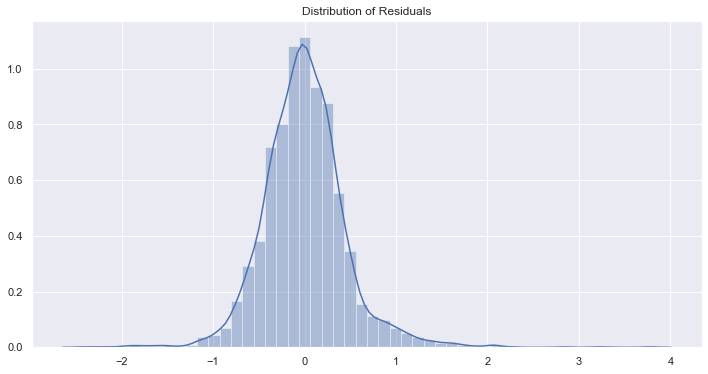


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Building a probability plot


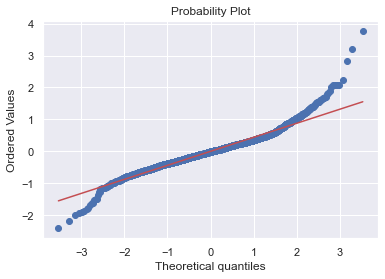


In your dataset you quite fat tails. You have 0.02 potential outliers (67 rows)


{'Satisfied': ['Linearity'],
 'Potentially': ['Multicollinearity', 'Autocorrelation', 'Sub-Normality'],
 'Violated': ['Autocorrelation', 'Normality']}

In [165]:
from Assumptions import Assumption_Tester_OLS as atols
atols(X,y).run_all()

### 4.1. Correcting mulitcollinearity

In [166]:
X1=add_constant(X)
vifs=pd.Series([VIF(X1.values,i) for i in range(X1.shape[1])],index=X1.columns)
vifs=pd.Series([VIF(X.values,i) for i in range(X.shape[1])],index=X.columns)
vifs[vifs>10]

C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Packaging_Box    14.093999
Pieces2          16.548877
dtype: float64

In [167]:
def func(column, X):
    if column:
        X=X.drop(column, axis=1)
    vifs=pd.Series([VIF(X.values,i) for i in range(X.shape[1])],index=X.columns)
    display(vifs[vifs>10])
    return X

In [168]:
X2=X.copy()

In [199]:
["Packaging_Box","Packaging_Box with backing card","Packaging_Other","Theme_Friends","Packaging_Not specified"]

['Packaging_Box',
 'Packaging_Box with backing card',
 'Packaging_Other',
 'Theme_Friends',
 'Packaging_Not specified']

In [174]:
X2=func('Packaging_Not specified',X2)

Series([], dtype: float64)

## 5. Final regression after correction

### 5.1. Final regression

In [175]:
sm.OLS(y,add_constant(X2)).fit().summary()

C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\statsmodels\regression\linear_model.py:1830: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Price_USD2   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     1000.
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        14:50:32   Log-Likelihood:                -2207.9
No. Observations:                3346   AIC:                             4448.
Df Residuals:                    3330   BIC:                             4546.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.2128      0.032     -6.634      0.000      -0.276      -0.150
Theme_City                        0.1490      0.033      4.464      0.000       0.084       0.214
Theme_Duplo                       1.1268      0.033     33.882      0.000       1.062       1.192
Theme_Ninjago                     0.2087      0.047      4.427      0.000       0.116       0.301
Theme_Other                       0.1795      0.021      8.752      0.000       0.139       0.220
Theme_Star Wars                   0.1045      0.033      3.168      0.002       0.040       0.169
Availability_Promotional         -0.5304      0.064     -8.285      0.000      -0.656      -0.405
Availability_Retail              -0.2851      0.020    -14.042      0.000      -0.325      -0.245
Availability_Retail - limited    -0.3115      0.036     -8.562      0.000      -0.383      -0.240
Availability_Unknown             -1.6455      0.470     -3.504      0.000      -2.566      -0.725
Packaging_Bucket                 -0.6451      0.136     -4.738      0.000      -0.912      -0.378
Packaging_Plastic box             2.5505      0.181     14.119      0.000       2.196       2.905
Packaging_Polybag                -0.4642      0.054     -8.552      0.000      -0.571      -0.358
Packaging_Tub                    -0.3307      0.126     -2.617      0.009      -0.579      -0.083
Pieces2                           0.6784      0.006    105.979      0.000       0.666       0.691
Outliers_Piece                    1.7995      0.273      6.589      0.000       1.264       2.335
Outliers_Minifigures                   0          0        nan        nan           0           0
==============================================================================
Omnibus:                      444.928   Durbin-Watson:                   1.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2399.256
Skew:                           0.513   Prob(JB):                         0.00
Kurtosis:                       7.019   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### 5.2. Building the model equation

In [176]:
df = pd.read_html(sm.OLS(y,add_constant(X2)).fit().summary().tables[1].as_html(),header=0,index_col=0)[0]

In [177]:
len(df)

17

In [178]:
c=df['coef'].values[0]
lst_coef=[df['coef'].values[i] for i in range(len(df))]

In [179]:
lst_var=["x"+str(i) for i in range(len(df))]

In [180]:
dct_coef={lst_var[i]:lst_coef[i] for i in range(len(df))}
dct_coef

{'x0': -0.2128,
 'x1': 0.149,
 'x2': 1.1268,
 'x3': 0.2087,
 'x4': 0.1795,
 'x5': 0.1045,
 'x6': -0.5304,
 'x7': -0.2851,
 'x8': -0.3115,
 'x9': -1.6455,
 'x10': -0.6451,
 'x11': 2.5505,
 'x12': -0.4642,
 'x13': -0.3307,
 'x14': 0.6784,
 'x15': 1.7995,
 'x16': 0.0}

In [181]:
str_equation=""

In [182]:
for i in range(len(df)):
    if i ==0:
        str_equation=str_equation+str(lst_coef[i])+" "
    else:
        if lst_coef[i]<0:
            str_equation=str_equation+str(lst_coef[i])+"*"+str(lst_var[i])+" "
        else:
            str_equation=str_equation+"+"+str(lst_coef[i])+"*"+str(lst_var[i])+" "

print("y=",str_equation)

y= -0.2128 +0.149*x1 +1.1268*x2 +0.2087*x3 +0.1795*x4 +0.1045*x5 -0.5304*x6 -0.2851*x7 -0.3115*x8 -1.6455*x9 -0.6451*x10 +2.5505*x11 -0.4642*x12 -0.3307*x13 +0.6784*x14 +1.7995*x15 +0.0*x16 


### 5.3. Final assumptions check

Fitting linear regression

R^2: 0.8183334652647039 

Coefficients
-------------------------------------
Intercept: -0.21283932848236065
Theme_City: 0.15
Theme_Duplo: 1.13
Theme_Ninjago: 0.21
Theme_Other: 0.18
Theme_Star Wars: 0.1
Availability_Promotional: -0.53
Availability_Retail: -0.29
Availability_Retail - limited: -0.31
Availability_Unknown: -1.65
Packaging_Bucket: -0.65
Packaging_Plastic box: 2.55
Packaging_Polybag: -0.46
Packaging_Tub: -0.33
Pieces2: 0.68
Outliers_Piece: 1.8
Outliers_Minifigures: 0.0

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


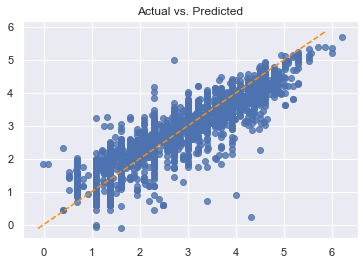

If non-linearity is apparent, consider adding a polynomial term 
		or using box-cox transformation to make X or y follow normal distribution



Building a correlation table


Parameters that are most likely VIOLATE linearity assumption and their correlation with Price_USD2


Series([], Name: Price_USD2, dtype: float64)


Parameters that are most likely FOLLOW linearity assumption and their correlation with Price_USD2


Pieces2    0.827721
Name: Price_USD2, dtype: float64


Assumption 2: Little to no multicollinearity among predictors


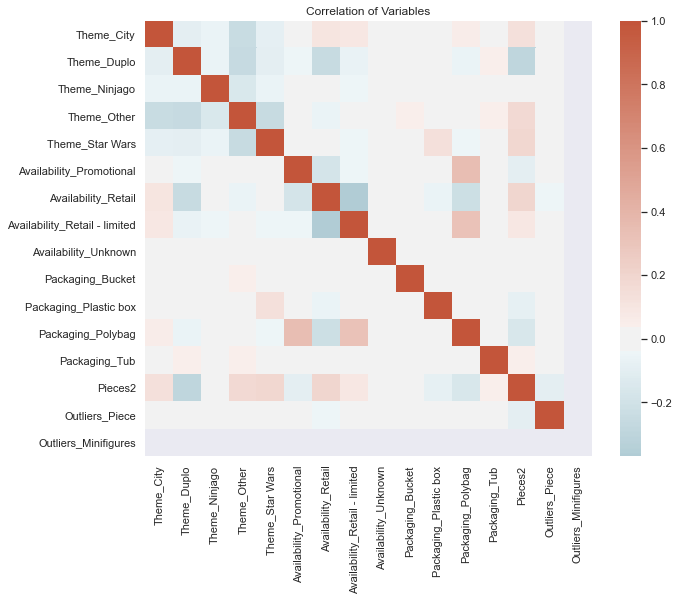

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Pieces2: 6.743126788384994
Availability_Retail: 3.36775692223714
Theme_Other: 2.4790640967776127
Availability_Retail - limited: 1.534434548734396
Theme_Star Wars: 1.431114383460322
Packaging_Polybag: 1.3651278114503478
Theme_City: 1.3250396642852251
Availability_Promotional: 1.2358053074890853
Theme_Duplo: 1.1771606521320832
Theme_Ninjago: 1.110533930925081
Packaging_Plastic box: 1.0221974264122928
Packaging_Tub: 1.0120056573379825
Packaging_Bucket: 1.009105859903612
Outliers_Piece: 1.0055008818715478
Availability_Unknown: 1.0011458958123391
Outliers_Minifigures: nan

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied

Assumption 3: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the d

C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


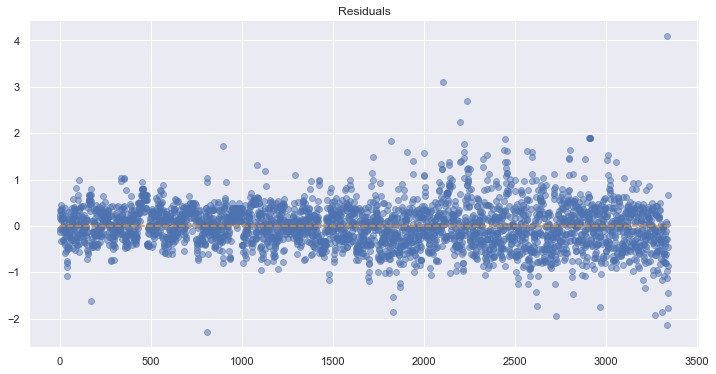

If heteroskedasticity is apparent, confidence intervals and predictions will be affected

Consider removing outliers and preprocessing features - nonlinear transformation can help


{'Lagrange Multiplier': 467.4246458213345,
 'pvalue for LM': 4.3303301972180705e-90,
 'F stats': 36.059307207195815,
 'pvalue for Fstats': 1.9535746679335322e-97}

Signs of positive autocorrelation 

Assumption potentially not satisfied 


Assumption 5: The error terms are kinda normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


C:\Users\Camille\Anaconda3\Anaconda33\lib\site-packages\statsmodels\stats\_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


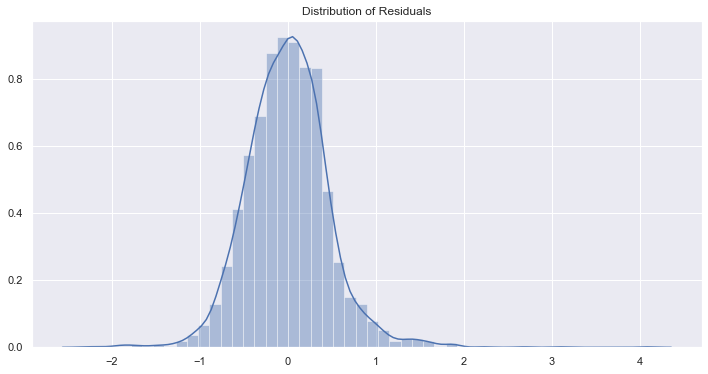


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Building a probability plot


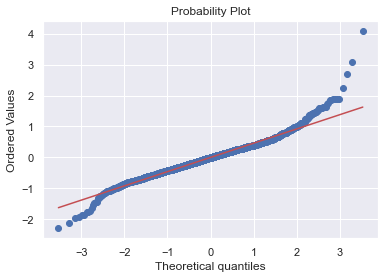


In your dataset you quite fat tails. You have 0.02 potential outliers (66 rows)


{'Satisfied': ['Linearity', 'Multicollinearity'],
 'Potentially': ['Autocorrelation', 'Sub-Normality'],
 'Violated': ['Autocorrelation', 'Normality']}

In [183]:
from Assumptions import Assumption_Tester_OLS as atols
atols(X2,y).run_all()

### 5.4. Plotting predictions

In [187]:
mod=sm.OLS(y,add_constant(X2)).fit()
y_pred=mod.predict(add_constant(X2))

#### a. Plotting predictions with boxcox

In [188]:
lego=pd.concat([y,y_pred],axis=1)

In [189]:
lego.columns=['Price','Price_predict']

Text(0.5, 1.0, 'Linear Regression for prices of lego sets - boxcox')

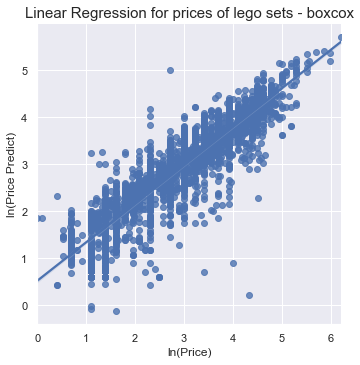

In [198]:
sns.lmplot(x='Price', y='Price_predict', data=lego)
plt.ylabel("ln(Price Predict)")
plt.xlabel("ln(Price)")
plt.title("Linear Regression for prices of lego sets - boxcox", fontsize=15)

#### b. Plotting without boxcox

In [192]:
exp_y=inv_boxcox(y, 0)
exp_y_pred=inv_boxcox(y_pred, 0)

In [193]:
lego_exp=pd.concat([exp_y,exp_y_pred],axis=1)

In [194]:
lego_exp.columns=['Price','Price_predict']

Text(0.5, 1.0, 'Linear Regression for prices of lego sets')

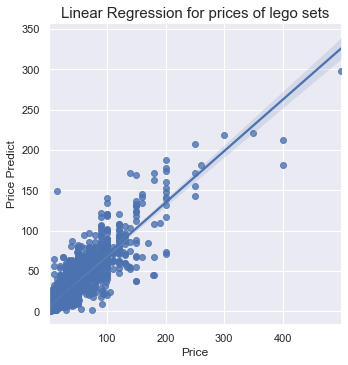

In [197]:
sns.lmplot(x='Price', y='Price_predict', data=lego_exp)
plt.ylabel("Price Predict")
plt.xlabel("Price")
plt.title("Linear Regression for prices of lego sets", fontsize=15)